In [1]:
import os
import torchaudio
import torch
import matplotlib.pyplot as plt
from torch.nn import Module, Linear, Sigmoid, LSTM, BCELoss
from torch.optim import Adam
import torch.nn.functional as F
from pytorch_model_summary import summary
from tqdm import tqdm
import numpy as np
import random

## Load Data

In [2]:
REFERENCE_CHANNEL = 0
SAME_LENGTH = False
THR_S = 0.5 # Threshold for speech IRM
THR_N = 0.5
N_PATH = "/project/data_asr/CHiME5/data/librenoise/free-sound/"#"/Users/danilfedorovsky/Documents/10 Collection/00 Studium/00 Letztes Semester/Masterarbeit/Data/noise/free-sound/"
S_PATH = "/project/data_asr/CHiME5/data/librenoise/dev/dev-clean/"#"/Users/danilfedorovsky/Documents/10 Collection/00 Studium/00 Letztes Semester/Masterarbeit/Data/LibriSpeech/dev-clean/"
def load_noise(N_PATH=N_PATH):
    noise = []
    for file in  os.listdir(N_PATH):
        if file[-4:] == ".wav":
            sound, _ = torchaudio.load(N_PATH+file)
            noise.append(sound)
    return noise


def load_speech(S_PATH=S_PATH):
    speech = []
    for folder in  os.listdir(S_PATH):
        if os.path.isdir(S_PATH+folder):
            for subfolder in os.listdir(S_PATH+folder):
                if os.path.isdir(S_PATH+folder+"/"+subfolder):
                    for file in os.listdir(S_PATH+folder+"/"+subfolder):
                        if file[-5:] == ".flac":
                            sound, _ = torchaudio.load(S_PATH+folder+"/"+subfolder+"/"+file)
                            if SAME_LENGTH:
                                try:
                                    sound = torch.narrow(sound,1,0,50000)# Narrow to 50000
                                except Exception:
                                    # add zeros to make sound 50000 long
                                    len_sound = sound.shape[1]
                                    add_zeros = 50000 - len_sound
                                    add_zeros = torch.zeros(add_zeros).reshape(1,-1)
                                    sound = torch.concat([sound,add_zeros],dim=1)
                            speech.append(sound)
    return speech

def add_noise_to_speech(speech, noise, ratio1: float, ratio2: float):
    X = []
    X2 = []
    newNoise = []
    for sample in speech:
        len_speech = sample.shape[1]
        sample_noise = random.choice(noise)
        while sample_noise.shape[1]<len_speech:
            sample_noise = torch.concat([sample_noise,sample_noise],dim=1)# Repeat to ensure noise is longer than speech
        sample_noise = torch.narrow(sample_noise,1,0,len_speech)# Shorten noise to same length as speech
        x = torch.add(sample,sample_noise*ratio1)# Same Ratio 1:1
        x2 = torch.add(sample,sample_noise*ratio2)# Same Ratio 1:1
        sample_noise = torch.narrow(sample_noise,1,0,len_speech)
        X.append(x)
        X2.append(x)
        newNoise.append(sample_noise)
    return X, X2, newNoise    

def prep_xij(trainX,i,j):
    real_part = trainX[i][j].real
    imag_part = trainX[i][j].imag
    return torch.cat((real_part.unsqueeze(2),imag_part.unsqueeze(2)),2)

# STFT
N_FFT = 1024
N_HOP = 256

stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)
istft = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, hop_length=N_HOP)


speech = load_speech()
noise = load_noise()
noise = noise[:20]
X, X2, noise = add_noise_to_speech(speech, noise, 0.2, 0.5)

In [3]:
stfts_mix = []
for n in range(0,len(X)):
    x_new = torch.concat([stft(X[n]),stft(X2[n])],dim=0)
    stfts_mix.append(x_new)

    
stfts_clean = []
for y in speech:
    y_new = stft(y)
    y_new = y_new.reshape(513,-1)
    stfts_clean.append(y_new)

stfts_noise = []
i = 0
for n in noise:
    try:
        n_new = stft(n)
        stfts_noise.append(n_new.reshape(513,-1))
    except Exception: #sometimes noises are very short, e.g. noise[697]
        continue


print(stfts_clean[0].shape)
print(stfts_mix[0][0].shape)
print(stfts_noise[0].shape)

torch.Size([513, 1371])
torch.Size([513, 1371])
torch.Size([513, 1371])


In [4]:
trainX = stfts_mix

def get_irms(stft_clean, stft_noise):
    mag_clean = stft_clean.abs() ** 2
    mag_noise = stft_noise.abs() ** 2
    irm_speech = mag_clean / (mag_clean + mag_noise)
    irm_noise = mag_noise / (mag_clean + mag_noise)
    return irm_speech[REFERENCE_CHANNEL], irm_noise[REFERENCE_CHANNEL]

trainY = []
for n in range(0,len(noise)):
    irm_speech, irm_noise = get_irms(stfts_clean[n].unsqueeze(0), stfts_noise[n].unsqueeze(0))
    irm_speech = (irm_speech>THR_S).float()
    irm_noise = (irm_noise>THR_N).float()
    trainY.append(torch.cat((irm_speech.unsqueeze(0),irm_noise.unsqueeze(0)),0))

# MaskNet + Training

In [45]:
# MASK NET
HIDDEN_SIZE=256 # 256
SAMPLE_RATE = 16000
INPUT_CHANNEL = 2 # Always two -> Real and Imaginary part 

class MaskNet(Module):
    def __init__(self,noise=False):
        super(MaskNet, self).__init__()
        # First subnet for speech prediction
        self.noise = noise
        self.lstm = LSTM(input_size=INPUT_CHANNEL, hidden_size=HIDDEN_SIZE, num_layers=2, bidirectional=True)
        self.fc = Linear(in_features=HIDDEN_SIZE*2 ,out_features=1)
        self.sigmoid = Sigmoid()

    def forward(self,x):
        # Speech prediction
        y, (h_n, c_n) = self.lstm(x)
        y = self.fc(y)
        speech_pred = self.sigmoid(y)
        return speech_pred.reshape(513,-1)#, noise_pred

print(summary(MaskNet(),torch.zeros((513, 196, 2))))

-----------------------------------------------------------------------------------------------------
      Layer (type)                                      Output Shape         Param #     Tr. Param #
            LSTM-1     [513, 196, 512], [4, 196, 256], [4, 196, 256]       2,109,440       2,109,440
          Linear-2                                     [513, 196, 1]             513             513
         Sigmoid-3                                     [513, 196, 1]               0               0
Total params: 2,109,953
Trainable params: 2,109,953
Non-trainable params: 0
-----------------------------------------------------------------------------------------------------


In [38]:
CUDA = True
EPOCHS = 1
NUM_CHANNEL = 2 # Number of Mic Inputs (>=2 for BF)
REFERENCE_CHANNEL = 0
INIT_LR = 0.01
BATCH_SIZE = 1

# if torch.cuda.is_available()
device =  torch.device('cuda:2') if CUDA else torch.device('cpu')
print("Mounted on:", device)
model = MaskNet().to(device)

lossBCE = BCELoss()

opt = Adam(model.parameters(), lr=INIT_LR)


H = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

def check_accuracy_training(speech_pred, y_s):
    speech_pred = (speech_pred>0.15).float()
    return float(torch.sum((speech_pred == y_s).float())/torch.sum(torch.ones(513,speech_pred.shape[1])))

def check_accuracy_validation(model):
    example_nr = int(np.random.random()*(len(speech)-len(trainX))+len(trainX))
    model.eval()
    pred = model(prep_xij(stfts_mix,example_nr,0).to(device))
    val_loss = lossBCE(pred,trainY[example_nr][0].to(device))
    pred = (pred>0.15).float()
    model.train()
    return float(torch.sum((pred == trainY[example_nr][0].to(device)).float())/torch.sum(torch.ones(513,stfts_mix[example_nr].shape[2])).to(device)),val_loss

print("[INFO] training the network...")

for epoch in range(0, EPOCHS):
    print("Epoch:",str(epoch+1)+"/"+str(EPOCHS))
    # Train Mode
    model.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    trainX = stfts_mix[:1000]#stfts_mix[:50]
    trainY = trainY
    for i in tqdm(range(0,len(trainX))): # Iterate over Training Examples
        for j in range(0,NUM_CHANNEL):# Iterate over channels
            (x, y_s, y_n) = (prep_xij(trainX,i,j).to(device),trainY[i][0].to(device),trainY[i][1].to(device))
            speech_pred=model(x)
            loss = lossBCE(speech_pred,y_s)
            # zero out the gradients, perform the backpropagation step, and update the weights
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            H["train_acc"].append(check_accuracy_training(speech_pred,y_s))
            H["train_loss"].append(float(loss))
        if i % 10 == 0:
            val_acc, val_loss = check_accuracy_validation(model)
            H["val_acc"].append(val_acc)
            H["val_loss"].append(float(val_loss))
        if i % 100 == 0:
            if i == 0:
                continue
            # if CUDA:
            #     torch.cuda.empty_cache()
            print("Average Training Accuracy at Iteration",str(i),":",np.mean(np.array(H["train_acc"])))
            print("Total Training Loss at Iteration",str(i),":",np.sum(np.array(H["train_loss"])))
            print("Average Validation Accuracy at Iteration",str(i),":",np.mean(np.array(H["val_acc"])))
            print("Total Validation Loss at Iteration",str(i),":",np.sum(np.array(H["val_loss"])))
            # Save
            PATH = "./modelLibre"
            torch.save(model.state_dict(), PATH + str(i) + ".pt")
            #torch.cuda.empty_cache()
            #model = MaskNet()
            #model.load_state_dict(torch.load(PATH + str(i) + ".pt"))
            # Reset H
            H = {
                "train_loss":[],
                "train_acc":[],
                "val_loss":[],
                "val_acc":[]
            }
PATH = "./modelLibre"
torch.save(model.state_dict(), PATH + "final" + ".pt")

Mounted on: cuda:2
[INFO] training the network...
Epoch: 1/1


  5%|▌         | 52/1000 [00:13<03:47,  4.16it/s]

Average Training Accuracy at Iteration 50 : 0.41877604252202255
Total Training Loss at Iteration 50 : 70.31286811828613
Average Validation Accuracy at Iteration 50 : 0.6601312160491943
Total Validation Loss at Iteration 50 : 4.262546062469482


 10%|█         | 102/1000 [00:28<04:46,  3.14it/s]

Average Training Accuracy at Iteration 100 : 0.47660007745027544
Total Training Loss at Iteration 100 : 76.21910497546196
Average Validation Accuracy at Iteration 100 : 0.36619754433631896
Total Validation Loss at Iteration 100 : 3.6941573917865753


 15%|█▌        | 152/1000 [00:42<02:57,  4.77it/s]

Average Training Accuracy at Iteration 150 : 0.4396034196950495
Total Training Loss at Iteration 150 : 70.39157828688622
Average Validation Accuracy at Iteration 150 : 0.6137997791171074
Total Validation Loss at Iteration 150 : 3.691232442855835


 20%|██        | 202/1000 [00:57<03:18,  4.03it/s]

Average Training Accuracy at Iteration 200 : 0.4329295129328966
Total Training Loss at Iteration 200 : 70.11248907446861
Average Validation Accuracy at Iteration 200 : 0.5634235352277756
Total Validation Loss at Iteration 200 : 3.3833883702754974


 25%|██▌       | 251/1000 [01:11<03:00,  4.14it/s]

Average Training Accuracy at Iteration 250 : 0.49486270036548374
Total Training Loss at Iteration 250 : 73.44674074649811
Average Validation Accuracy at Iteration 250 : 0.3726128563284874
Total Validation Loss at Iteration 250 : 3.575808584690094


 30%|███       | 301/1000 [01:24<03:38,  3.19it/s]

Average Training Accuracy at Iteration 300 : 0.4934377081692219
Total Training Loss at Iteration 300 : 73.72587895393372
Average Validation Accuracy at Iteration 300 : 0.3858943209052086
Total Validation Loss at Iteration 300 : 3.532351404428482


 35%|███▌      | 352/1000 [01:39<02:41,  4.01it/s]

Average Training Accuracy at Iteration 350 : 0.488354072868824
Total Training Loss at Iteration 350 : 72.5900838971138
Average Validation Accuracy at Iteration 350 : 0.4653764098882675
Total Validation Loss at Iteration 350 : 3.7405008673667908


 40%|████      | 402/1000 [01:50<02:05,  4.75it/s]

Average Training Accuracy at Iteration 400 : 0.5270171346515418
Total Training Loss at Iteration 400 : 76.86130949854851
Average Validation Accuracy at Iteration 400 : 0.6231651723384857
Total Validation Loss at Iteration 400 : 4.971527934074402


 45%|████▌     | 451/1000 [02:03<02:41,  3.39it/s]

Average Training Accuracy at Iteration 450 : 0.44735669758170843
Total Training Loss at Iteration 450 : 70.74697035551071
Average Validation Accuracy at Iteration 450 : 0.639449417591095
Total Validation Loss at Iteration 450 : 4.718428790569305


 50%|█████     | 502/1000 [02:15<01:39,  4.99it/s]

Average Training Accuracy at Iteration 500 : 0.4680721125937998
Total Training Loss at Iteration 500 : 77.2165048122406
Average Validation Accuracy at Iteration 500 : 0.4569924041628838
Total Validation Loss at Iteration 500 : 4.733505725860596


 55%|█████▌    | 552/1000 [02:28<01:51,  4.01it/s]

Average Training Accuracy at Iteration 550 : 0.4119665690138936
Total Training Loss at Iteration 550 : 71.95240640640259
Average Validation Accuracy at Iteration 550 : 0.44135124124586583
Total Validation Loss at Iteration 550 : 4.044998288154602


 60%|██████    | 601/1000 [02:43<03:18,  2.01it/s]

Average Training Accuracy at Iteration 600 : 0.43765204813331365
Total Training Loss at Iteration 600 : 67.65626123547554
Average Validation Accuracy at Iteration 600 : 0.5159118801355362
Total Validation Loss at Iteration 600 : 4.3883819580078125


 65%|██████▌   | 651/1000 [03:02<02:16,  2.56it/s]

Average Training Accuracy at Iteration 650 : 0.4564770134165883
Total Training Loss at Iteration 650 : 80.66560795903206
Average Validation Accuracy at Iteration 650 : 0.6001049660146236
Total Validation Loss at Iteration 650 : 4.235708713531494


 70%|███████   | 701/1000 [03:15<01:27,  3.40it/s]

Average Training Accuracy at Iteration 700 : 0.4110315097309649
Total Training Loss at Iteration 700 : 77.66917169094086
Average Validation Accuracy at Iteration 700 : 0.684445720911026
Total Validation Loss at Iteration 700 : 4.316824316978455


 75%|███████▌  | 751/1000 [03:28<01:21,  3.05it/s]

Average Training Accuracy at Iteration 750 : 0.45128449469804766
Total Training Loss at Iteration 750 : 74.78016851842403
Average Validation Accuracy at Iteration 750 : 0.3383454717695713
Total Validation Loss at Iteration 750 : 3.426261067390442


 80%|████████  | 801/1000 [03:43<01:06,  2.98it/s]

Average Training Accuracy at Iteration 800 : 0.4992606684565544
Total Training Loss at Iteration 800 : 84.16096272319555
Average Validation Accuracy at Iteration 800 : 0.6149568140506745
Total Validation Loss at Iteration 800 : 3.227549731731415


 85%|████████▌ | 851/1000 [03:58<00:57,  2.60it/s]

Average Training Accuracy at Iteration 850 : 0.46368033554404975
Total Training Loss at Iteration 850 : 77.98603874444962
Average Validation Accuracy at Iteration 850 : 0.5357459098100662
Total Validation Loss at Iteration 850 : 4.711104691028595


 90%|█████████ | 902/1000 [04:11<00:20,  4.80it/s]

Average Training Accuracy at Iteration 900 : 0.48942840203642846
Total Training Loss at Iteration 900 : 84.40127548575401
Average Validation Accuracy at Iteration 900 : 0.6044928133487701
Total Validation Loss at Iteration 900 : 4.677377104759216


 95%|█████████▌| 951/1000 [04:22<00:10,  4.47it/s]

Average Training Accuracy at Iteration 950 : 0.5284211461618543
Total Training Loss at Iteration 950 : 80.69729187339544
Average Validation Accuracy at Iteration 950 : 0.29371208138763905
Total Validation Loss at Iteration 950 : 5.022665232419968


100%|██████████| 1000/1000 [04:40<00:00,  3.57it/s]


In [34]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "max_split_size_mb:1024"
print(os.environ['PYTORCH_CUDA_ALLOC_CONF'])

del os.environ['PYTORCH_CUDA_ALLOC_CONF']

max_split_size_mb:1024


In [36]:
torch.cuda.device_count()

4

In [37]:
device = torch.device('cuda:2')
print(device)

cuda:2


In [15]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

45746688
3693084672
45746688
65011712


In [38]:
torch.cuda.empty_cache()

In [17]:
print(torch.cuda.current_device())
torch.cuda.memory_summary(device=None, abbreviated=False)

0


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   30200 KB |    6960 MB |    7016 MB |    6987 MB |\n|       from large pool |   30198 KB |    6960 MB |    7000 MB |    6970 MB |\n|       from small pool |       2 KB |       4 MB |      16 MB |      16 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |   30200 KB |    6960 MB |    7016 MB |    6987 MB |\n|       from large pool |   30198 KB |    6960 MB |

## Load Model & Evaluate

In [ ]:
PATH = "./ModelLibreOneNoise.pt"
model = MaskNet()
model.load_state_dict(torch.load(PATH))
model.eval()

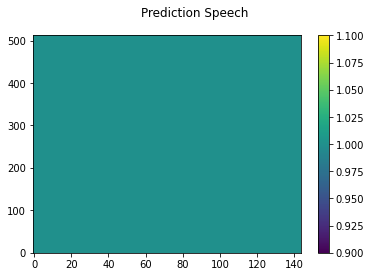

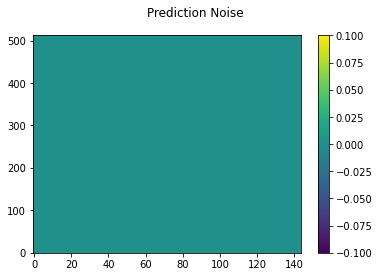

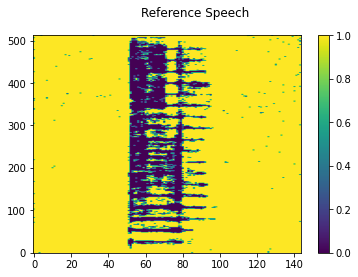

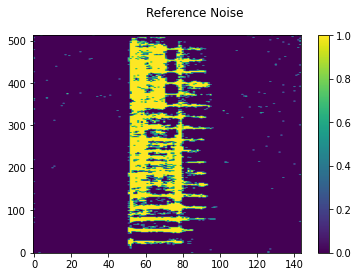

In [44]:
def evaluate_example(e_nr):
    model.eval()
    speech_pred = (model(prep_xij(trainX,e_nr,0).to(device))>0.2).float()
    noise_pred = torch.ones([513,stfts_mix[e_nr].shape[2]]).to(device)-speech_pred
    plot_mask(speech_pred, title="Prediction Speech")
    plot_mask(noise_pred, title="Prediction Noise")
    plot_mask(trainY[e_nr][0], title="Reference Speech")
    plot_mask(trainY[e_nr][1], title="Reference Noise")

def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.cpu().detach().numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

def maskToWave(speech_pred,noise_pred,mix,i):
        model.eval()
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(mix[i], speech_pred)
        psd_noise = psd_transform(mix[i], noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(mix[i], psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
        waveform_souden = istft(stft_souden, length=len(X[i][0]))#X[i].shape[-1])
        return waveform_souden.reshape(-1)

evaluate_example(1)

In [14]:
speech_pred = trainY[0][0]
noise_pred = trainY[0][1]

def evaluateSiSNR(wave, i):
    def si_snr(estimate, reference, epsilon=1e-8):
        estimate = estimate - estimate.mean()
        reference = reference - reference.mean()
        reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
        mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
        scale = mix_pow / (reference_pow + epsilon)

        reference = scale * reference
        error = estimate - reference

        reference_pow = reference.pow(2)
        error_pow = error.pow(2)

        reference_pow = reference_pow.mean(axis=1)
        error_pow = error_pow.mean(axis=1)

        si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
        return si_snr.item()
    score = si_snr(wave, speech[i])
    print(f"Si-SNR score: {score}") 
    return score

def maskToWave(speech_pred,noise_pred,mix,i):
        model.eval()
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(mix[i], speech_pred)
        psd_noise = psd_transform(mix[i], noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(mix[i], psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
        waveform_souden = istft(stft_souden, length=len(X[i][0]))#X[i].shape[-1])
        return waveform_souden.reshape(-1)

def save_sample(i,wave,sample_rate=SAMPLE_RATE):
    model.eval()
    wave = wave
    torchaudio.save("sampleall_output.wav",wave.reshape(1,-1),sample_rate)
    torchaudio.save("sampleall_reference.wav", speech[i].reshape(1,-1),sample_rate)
    torchaudio.save("sampleall_input.wav", X[i].reshape(1,-1),sample_rate)


sample_nr = 51
speech_pred = (model(prep_xij(stfts_mix,sample_nr,0))>0.15).float()
noise_pred = torch.ones([513,speech_pred.shape[1]])-speech_pred
wave = maskToWave(speech_pred,noise_pred,stfts_mix,sample_nr)
save_sample(sample_nr, wave=wave)
score = evaluateSiSNR(wave,sample_nr)#Should be ~16

Si-SNR score: -0.38113975524902344
